<a href="https://colab.research.google.com/github/pvh95/intel_image_classification_cnn_keras/blob/main/intel_image_classification_cnn_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import PIL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Conv2D,Flatten,Dropout,AlphaDropout,MaxPool2D,Flatten,Activation,BatchNormalization, MaxPooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from PIL import Image
import os
import glob 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import matplotlib.image as mpimg

np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
main_dir = '../input/intel-image-classification/'
subdir_lst = ['seg_train/', 'seg_test/', 'seg_pred/']

for subdir in subdir_lst:
  total = 0
  for root, dirs, files in os.walk(main_dir + subdir):
    total += len(files)

  print(subdir, '-------', total, 'instances')

seg_train/ ------- 14034 instances
seg_test/ ------- 3000 instances
seg_pred/ ------- 7301 instances


In [ ]:
keras.__version__

'2.4.0'

In [ ]:
PIL.__version__

'7.2.0'

In [ ]:
paths = glob.glob(main_dir + 'seg_train/' + 'seg_train/' + '*')
l = len(main_dir + 'seg_train/' + 'seg_train/')
labels = []
for path in paths:
  labels.append(path[l:])

print(labels)


['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


In [ ]:
train_datagen = ImageDataGenerator(rescale=1 / 255,
                                  shear_range = 0.2,
                                  zoom_range = 0.5,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  horizontal_flip = True,
                                  rotation_range = 30,
                                  validation_split = 0.15,
                                  )

valid_datagen = ImageDataGenerator(rescale= 1 / 255, validation_split = 0.15)
test_datagen = ImageDataGenerator(rescale = 1 / 255)

In [ ]:
train_generator = train_datagen.flow_from_directory(main_dir + 'seg_train/' + 'seg_train/',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 seed=42,
                                                 shuffle = True, 
                                                 interpolation="lanczos",
                                                 subset='training',
                                                 class_mode = 'categorical') # set as training data
   

validation_generator = valid_datagen.flow_from_directory(main_dir + 'seg_train/' + 'seg_train/',
                                                         target_size = (150, 150),
                                                         batch_size = 32,
                                                         seed = 42,
                                                         shuffle = True,
                                                         interpolation="lanczos",
                                                         subset='validation',
                                                         class_mode = 'categorical') # set as validation data

test_generator = test_datagen.flow_from_directory(main_dir + 'seg_test/' + 'seg_test/',
                                                target_size = (150, 150),
                                                batch_size = 30,
                                                seed = 42,
                                                shuffle = False,
                                                interpolation="lanczos",
                                                class_mode='categorical') # set as test data





Found 11932 images belonging to 6 classes.
Found 2102 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
validation_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam

# First toy example

Epoch 1/7
373/373 [==============================] - 142s 369ms/step - loss: 1.3410 - accuracy: 0.4437 - val_loss: 1.1162 - val_accuracy: 0.5861
Epoch 2/7
373/373 [==============================] - 78s 208ms/step - loss: 0.9956 - accuracy: 0.6170 - val_loss: 0.8718 - val_accuracy: 0.6751
Epoch 3/7
373/373 [==============================] - 77s 208ms/step - loss: 0.8843 - accuracy: 0.6675 - val_loss: 0.7511 - val_accuracy: 0.7374
Epoch 4/7
373/373 [==============================] - 78s 208ms/step - loss: 0.8041 - accuracy: 0.7023 - val_loss: 0.6540 - val_accuracy: 0.7574
Epoch 5/7
373/373 [==============================] - 77s 207ms/step - loss: 0.7825 - accuracy: 0.7078 - val_loss: 0.6460 - val_accuracy: 0.7607
Epoch 6/7
373/373 [==============================] - 78s 208ms/step - loss: 0.7300 - accuracy: 0.7262 - val_loss: 0.6338 - val_accuracy: 0.7764
Epoch 7/7
373/373 [==============================] - 78s 208ms/step - loss: 0.6884 - accuracy: 0.7479 - val_loss: 0.5841 - val_accuracy

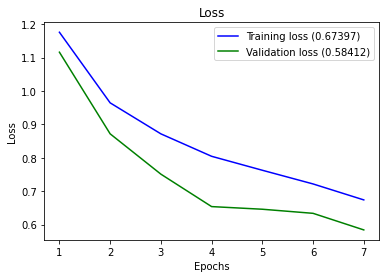

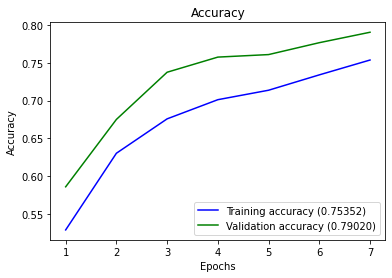

100/100 [==============================] - 17s 166ms/step - loss: 0.6146 - accuracy: 0.7907
test loss, test acc: [0.6146482825279236, 0.7906666398048401]


In [ ]:
classifier = Sequential([
    Conv2D(16, (3,3), padding='same', input_shape = (150,150,3), activation = 'relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3,3), padding='same', activation = 'relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3,3), padding='same', activation = 'relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3,3), padding='same', activation = 'relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units = 64, activation = 'relu'),
    Dense(units = 16, activation = 'relu'),
    Dense(units = 6, activation = 'softmax')
])



classifier.compile(optimizer = 'adam',
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])

history = classifier.fit(train_generator, batch_size=40, epochs=7,
                   validation_data=validation_generator)

plot_history(history)

results = classifier.evaluate(test_generator, batch_size = 40)
print("test loss, test acc:", results)



True label: sea
Predicted label: sea


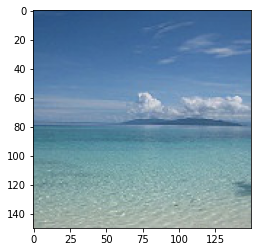

True label: mountain
Predicted label: mountain


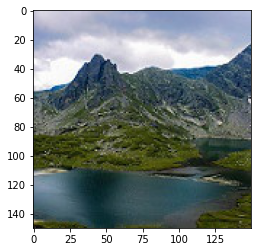

True label: sea
Predicted label: sea


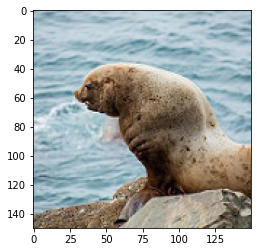

True label: buildings
Predicted label: buildings


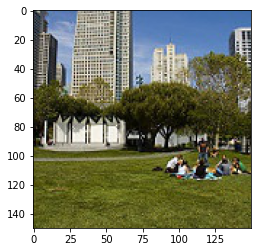

True label: mountain
Predicted label: mountain


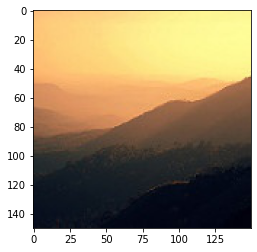

In [ ]:
labs = ["buildings","forest", "glacier", "mountain", "sea", "street"]
imgs, ls = next(validation_generator)

predictions = classifier.predict(x=imgs, steps=len(imgs), verbose=0)
predictions = np.argmax(predictions, axis = -1)

for i in range(5):
    index = np.where(ls[:5][i] == 1)[0][0]
    index2 = predictions[:5][i]
    print("True label:", labs[index])
    print("Predicted label:", labs[index2])
    plt.imshow(imgs[i])
    plt.show()

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", 
                               patience=3,
                               verbose=1,
                               restore_best_weights=True)

lr_reduc = ReduceLROnPlateau(monitor='val_loss',
                            patience=3,
                            verbose=1,
                            factor=0.2,
                            min_lr=0.00001)

callbacks = [early_stopping, lr_reduc]

In [ ]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size + 1
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size + 1

In [ ]:
STEP_SIZE_TRAIN

373

In [ ]:
STEP_SIZE_VALID

66

# Visualization

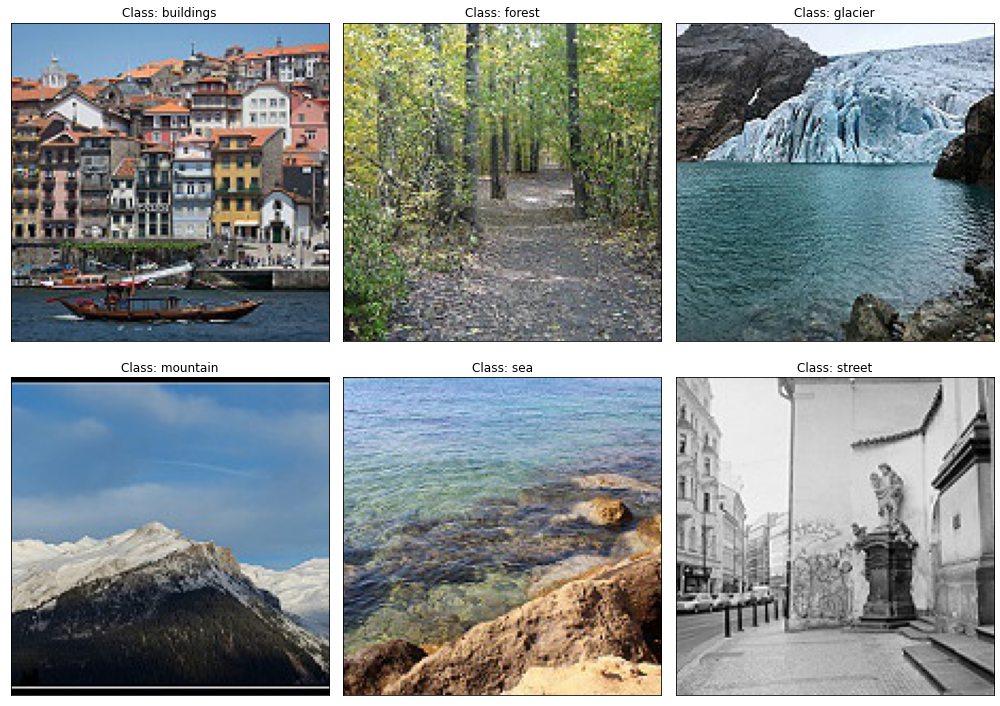

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(14, 10))
ax=ax.ravel()
plt.setp(ax, xticks=[], yticks=[])
plt.subplots_adjust(hspace=0.1)
plt.tight_layout()

train_folder=os.path.join('/kaggle/input/intel-image-classification/', 'seg_train/', 'seg_train/')

for i,_dir in enumerate(['buildings/', 'forest/', 'glacier/', 'mountain/', 'sea/', 'street/']):
    im_file = os.listdir(train_folder+_dir)[3]
    full_path = train_folder+_dir+im_file
    ax[i].imshow(plt.imread(full_path), cmap='gray')
    ax[i].set_title('Class: {}'.format(_dir[:-1]))

#plt.savefig('examples.jpg')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


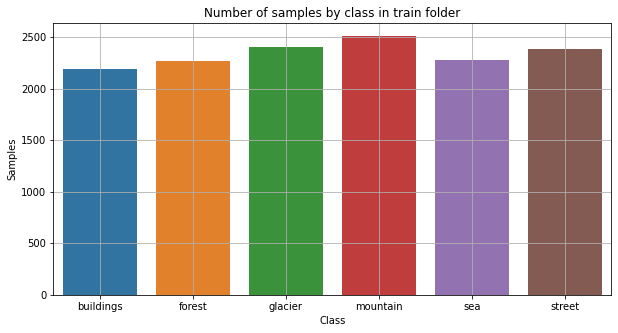

In [ ]:
train_folder=os.path.join('/kaggle/input/intel-image-classification/', 'seg_train/', 'seg_train/')
n_sizes={}

for i,_dir in enumerate(['buildings/', 'forest/', 'glacier/', 'mountain/', 'sea/', 'street/']):
    size=len(os.listdir(train_folder+_dir))
    n_sizes[_dir[:-1]]=size
    
plt.figure(figsize=(10,5))
sns.barplot(list(n_sizes.keys()), list(n_sizes.values()))

plt.xlabel('Class')
plt.ylabel('Samples')
plt.title('Number of samples by class in train folder')
plt.grid()
plt.savefig('samples_dist.jpg')
plt.show()

# Toy model

In [ ]:
import tensorflow.keras.models
import tensorflow.keras.layers as Layers
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 23, 23, 100)       126100    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 50)       

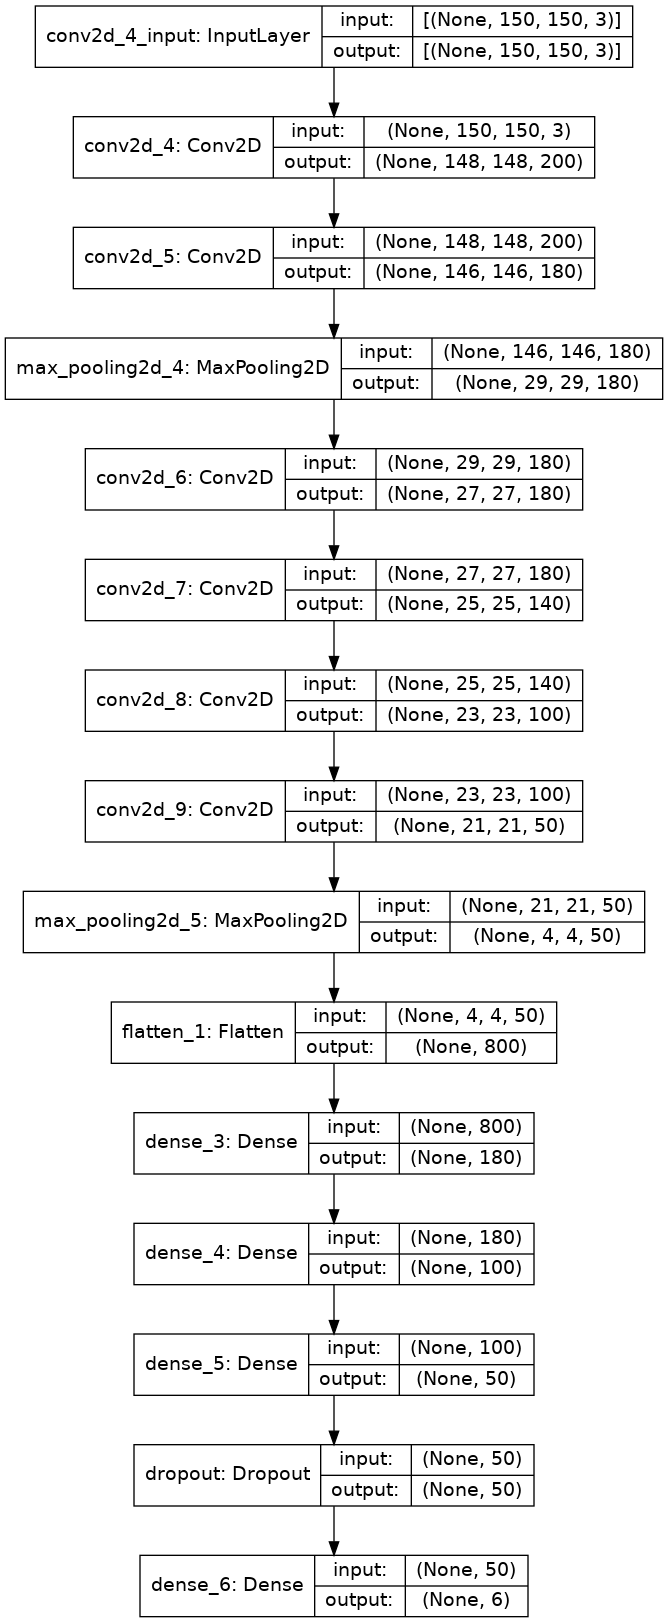

In [ ]:
toy_model = Sequential()

toy_model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
toy_model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
toy_model.add(Layers.MaxPool2D(5,5))
toy_model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
toy_model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
toy_model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
toy_model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
toy_model.add(Layers.MaxPool2D(5,5))
toy_model.add(Layers.Flatten())
toy_model.add(Layers.Dense(180,activation='relu'))
toy_model.add(Layers.Dense(100,activation='relu'))
toy_model.add(Layers.Dense(50,activation='relu'))
toy_model.add(Layers.Dropout(rate=0.5))
toy_model.add(Layers.Dense(6,activation='softmax'))

toy_model.summary()
SVG(model_to_dot(toy_model).create(prog='dot', format='svg'))
Utils.plot_model(toy_model,to_file='model.png',show_shapes=True)

In [ ]:
toy_model.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

r = toy_model.fit(
  train_generator, epochs = 10, validation_data = validation_generator,
    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID, callbacks = callbacks
)

Epoch 1/10
373/373 [==============================] - 817s 2s/step - loss: 1.5791 - accuracy: 0.3177 - val_loss: 1.1063 - val_accuracy: 0.5528
Epoch 2/10
373/373 [==============================] - 791s 2s/step - loss: 1.2265 - accuracy: 0.5182 - val_loss: 1.0933 - val_accuracy: 0.5999
Epoch 3/10
373/373 [==============================] - 791s 2s/step - loss: 1.1271 - accuracy: 0.5601 - val_loss: 0.9689 - val_accuracy: 0.6427
Epoch 4/10
373/373 [==============================] - 791s 2s/step - loss: 1.0490 - accuracy: 0.5932 - val_loss: 0.8381 - val_accuracy: 0.6908
Epoch 5/10
373/373 [==============================] - 791s 2s/step - loss: 0.9789 - accuracy: 0.6475 - val_loss: 0.9059 - val_accuracy: 0.6784
Epoch 6/10
373/373 [==============================] - 791s 2s/step - loss: 0.9417 - accuracy: 0.6551 - val_loss: 0.7158 - val_accuracy: 0.7364
Epoch 7/10
373/373 [==============================] - 791s 2s/step - loss: 0.8719 - accuracy: 0.6819 - val_loss: 0.6590 - val_accuracy: 0.7678

In [ ]:
results = toy_model.evaluate(test_generator)

print("test loss, test acc:", results)

100/100 [==============================] - 171s 2s/step - loss: 0.6211 - accuracy: 0.7833
test loss, test acc: [0.6211212277412415, 0.7833333611488342]


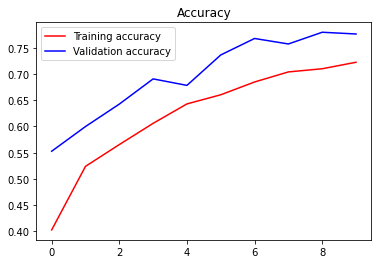

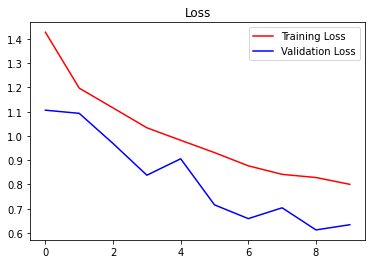

In [ ]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

# **InceptV3**

In [ ]:
inceptV3 = InceptionV3(input_shape = (150, 150, 3), 
                        include_top = False, 
                        weights = 'imagenet')


inceptV3.trainable = False

#pre_trained_model.summary()

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
model_inceptV3 = Sequential([
    inceptV3,
    Flatten(),
    Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    AlphaDropout(rate=0.2),
    Dense(6, activation='softmax')
])

####Adam
model_inceptV3.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

Epoch 1/10
373/373 [==============================] - 83s 211ms/step - loss: 1.4700 - accuracy: 0.6820 - val_loss: 0.5346 - val_accuracy: 0.8397
Epoch 2/10
373/373 [==============================] - 76s 204ms/step - loss: 0.5892 - accuracy: 0.7850 - val_loss: 0.4174 - val_accuracy: 0.8649
Epoch 3/10
373/373 [==============================] - 77s 205ms/step - loss: 0.5175 - accuracy: 0.8010 - val_loss: 0.4507 - val_accuracy: 0.8539
Epoch 4/10
373/373 [==============================] - 75s 202ms/step - loss: 0.5154 - accuracy: 0.8089 - val_loss: 0.4966 - val_accuracy: 0.8497
Epoch 5/10
373/373 [==============================] - 77s 207ms/step - loss: 0.4863 - accuracy: 0.8265 - val_loss: 0.3753 - val_accuracy: 0.8777
Epoch 6/10
373/373 [==============================] - 76s 203ms/step - loss: 0.4653 - accuracy: 0.8357 - val_loss: 0.3795 - val_accuracy: 0.8811
Epoch 7/10
373/373 [==============================] - 75s 201ms/step - loss: 0.4629 - accuracy: 0.8335 - val_loss: 0.3792 - val_ac

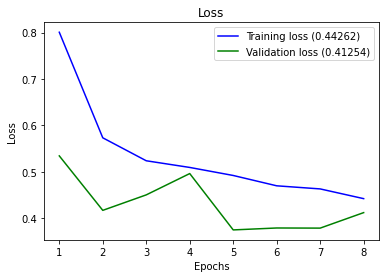

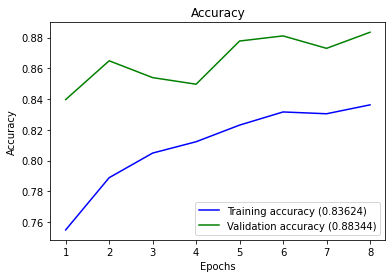

In [ ]:
history_inceptV3_1 = model_inceptV3.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = callbacks
                    )

plot_history(history_inceptV3_1)

#With Lanczos interpolation

In [ ]:
history_inceptV3_1.history

{'loss': [0.800603985786438,
  0.5734956860542297,
  0.5240867137908936,
  0.5097321271896362,
  0.4924575388431549,
  0.47022929787635803,
  0.4635344445705414,
  0.4426177740097046],
 'accuracy': [0.7549446821212769,
  0.7888870239257812,
  0.8048943877220154,
  0.8122695088386536,
  0.8230807781219482,
  0.83162921667099,
  0.8304558992385864,
  0.83623868227005],
 'val_loss': [0.5345931053161621,
  0.41741079092025757,
  0.450718492269516,
  0.496582955121994,
  0.37532681226730347,
  0.37947869300842285,
  0.37919342517852783,
  0.41253602504730225],
 'val_accuracy': [0.8396764993667603,
  0.8648905754089355,
  0.8539485931396484,
  0.8496670126914978,
  0.8777354955673218,
  0.8810656666755676,
  0.8729780912399292,
  0.8834443092346191],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}

In [ ]:
results_inceptV3_1 = model_inceptV3.evaluate(test_generator)
print("test loss, test acc:", results_inceptV3_1)



#With Lanczos interpolation

100/100 [==============================] - 5s 48ms/step - loss: 0.3251 - accuracy: 0.8820
test loss, test acc: [0.3250792622566223, 0.8820000290870667]


Epoch 1/10
373/373 [==============================] - 90s 224ms/step - loss: 0.6540 - accuracy: 0.7649 - val_loss: 0.4025 - val_accuracy: 0.8825
Epoch 2/10
373/373 [==============================] - 83s 224ms/step - loss: 0.4364 - accuracy: 0.8504 - val_loss: 0.3712 - val_accuracy: 0.8996
Epoch 3/10
373/373 [==============================] - 84s 226ms/step - loss: 0.3599 - accuracy: 0.8755 - val_loss: 0.2947 - val_accuracy: 0.9153
Epoch 4/10
373/373 [==============================] - 83s 222ms/step - loss: 0.3099 - accuracy: 0.8979 - val_loss: 0.3107 - val_accuracy: 0.9129
Epoch 5/10
373/373 [==============================] - 83s 222ms/step - loss: 0.2817 - accuracy: 0.9054 - val_loss: 0.2963 - val_accuracy: 0.9091
Epoch 6/10
373/373 [==============================] - 84s 225ms/step - loss: 0.2818 - accuracy: 0.8972 - val_loss: 0.2896 - val_accuracy: 0.9196
Epoch 7/10
373/373 [==============================] - 83s 223ms/step - loss: 0.2460 - accuracy: 0.9146 - val_loss: 0.3416 - val_ac

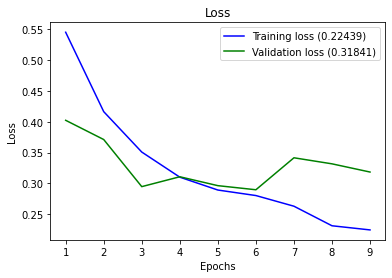

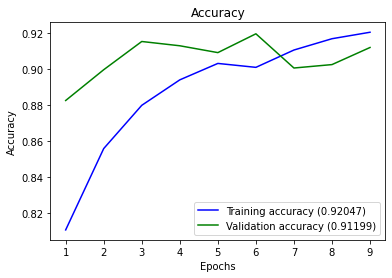

In [ ]:
inceptV3.trainable = True

###Adam
model_inceptV3.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


history_inceptV3_2 = model_inceptV3.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = callbacks
                    )

plot_history(history_inceptV3_2)

In [ ]:
history_inceptV3_2.history

{'loss': [0.545515775680542,
  0.41652044653892517,
  0.3508817255496979,
  0.3100980818271637,
  0.2891792356967926,
  0.28021836280822754,
  0.26289576292037964,
  0.23112896084785461,
  0.2243899255990982],
 'accuracy': [0.8105095624923706,
  0.8557659983634949,
  0.8798189759254456,
  0.8939825892448425,
  0.9031176567077637,
  0.9009386301040649,
  0.910576581954956,
  0.9168621897697449,
  0.9204659461975098],
 'val_loss': [0.4024675190448761,
  0.37122172117233276,
  0.29469749331474304,
  0.3107394576072693,
  0.296294242143631,
  0.28962501883506775,
  0.34156298637390137,
  0.3317425549030304,
  0.31840530037879944],
 'val_accuracy': [0.8824928402900696,
  0.8996194005012512,
  0.9153187274932861,
  0.9129400849342346,
  0.9091341495513916,
  0.9196003675460815,
  0.9005708694458008,
  0.9024738073348999,
  0.9119885563850403],
 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04]}

In [ ]:
results_inceptV3_2 = model_inceptV3.evaluate(test_generator)
print("test loss, test acc:", results_inceptV3_2)

100/100 [==============================] - 5s 46ms/step - loss: 0.2858 - accuracy: 0.9200
test loss, test acc: [0.28579142689704895, 0.9200000166893005]


# **MobileNetV2**

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

mnV2 = MobileNetV2(input_shape = (150, 150, 3), 
                include_top = False, 
                weights = 'imagenet')


mnV2.trainable = False

#pre_trained_model.summary()

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model_mnV2 = Sequential([
    mnV2,
    Flatten(),
    Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    AlphaDropout(rate=0.2),
    Dense(6, activation='softmax')
])

model_mnV2.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

Epoch 1/10
373/373 [==============================] - 78s 204ms/step - loss: 2.0628 - accuracy: 0.6370 - val_loss: 0.4144 - val_accuracy: 0.8487
Epoch 2/10
373/373 [==============================] - 76s 204ms/step - loss: 0.6274 - accuracy: 0.7645 - val_loss: 0.4935 - val_accuracy: 0.8397
Epoch 3/10
373/373 [==============================] - 73s 196ms/step - loss: 0.5459 - accuracy: 0.8103 - val_loss: 0.3529 - val_accuracy: 0.8911
Epoch 4/10
373/373 [==============================] - 73s 196ms/step - loss: 0.5011 - accuracy: 0.8141 - val_loss: 0.3550 - val_accuracy: 0.8930
Epoch 5/10
373/373 [==============================] - 74s 198ms/step - loss: 0.4964 - accuracy: 0.8209 - val_loss: 0.3312 - val_accuracy: 0.8987
Epoch 6/10
373/373 [==============================] - 75s 200ms/step - loss: 0.4592 - accuracy: 0.8262 - val_loss: 0.3514 - val_accuracy: 0.8911
Epoch 7/10
373/373 [==============================] - 74s 197ms/step - loss: 0.4511 - accuracy: 0.8331 - val_loss: 0.3241 - val_ac

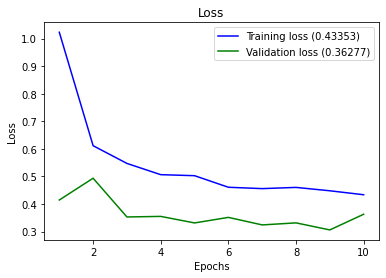

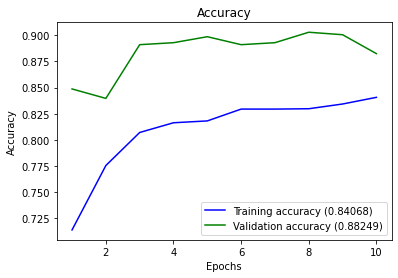

In [ ]:
history_mnV2_1 = model_mnV2.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = callbacks
                    )

plot_history(history_mnV2_1)

#With Lanczos interpolation

In [ ]:
history_mnV2_1.history

{'loss': [1.023237705230713,
  0.6115103363990784,
  0.5472052693367004,
  0.5063949227333069,
  0.502697229385376,
  0.46068692207336426,
  0.4557862877845764,
  0.46016010642051697,
  0.4479442238807678,
  0.43352705240249634],
 'accuracy': [0.7138786315917969,
  0.7754777073860168,
  0.8070734143257141,
  0.8163761496543884,
  0.8181360960006714,
  0.8294501900672913,
  0.8294501900672913,
  0.8297854661941528,
  0.8343110680580139,
  0.8406805396080017],
 'val_loss': [0.41437575221061707,
  0.4934863746166229,
  0.35288235545158386,
  0.3549729287624359,
  0.3312249779701233,
  0.351363867521286,
  0.32405710220336914,
  0.33146005868911743,
  0.3059004545211792,
  0.36277246475219727],
 'val_accuracy': [0.8487154841423035,
  0.8396764993667603,
  0.8910561203956604,
  0.8929590582847595,
  0.8986679315567017,
  0.8910561203956604,
  0.8929590582847595,
  0.9029495716094971,
  0.9005708694458008,
  0.8824928402900696],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,

In [ ]:
results_mnV2_1 = model_mnV2.evaluate(test_generator)
print("test loss, test acc:", results_mnV2_1)

#With Lanczos interpolation

100/100 [==============================] - 5s 51ms/step - loss: 0.3382 - accuracy: 0.8800
test loss, test acc: [0.33817094564437866, 0.8799999952316284]


Epoch 1/10
373/373 [==============================] - 88s 227ms/step - loss: 0.6559 - accuracy: 0.7639 - val_loss: 1.0351 - val_accuracy: 0.8030
Epoch 2/10
373/373 [==============================] - 83s 223ms/step - loss: 0.4276 - accuracy: 0.8520 - val_loss: 0.5343 - val_accuracy: 0.8815
Epoch 3/10
373/373 [==============================] - 85s 227ms/step - loss: 0.3679 - accuracy: 0.8697 - val_loss: 0.6853 - val_accuracy: 0.8744
Epoch 4/10
373/373 [==============================] - 84s 226ms/step - loss: 0.3323 - accuracy: 0.8816 - val_loss: 0.4779 - val_accuracy: 0.9077
Epoch 5/10
373/373 [==============================] - 84s 226ms/step - loss: 0.3086 - accuracy: 0.8938 - val_loss: 0.4714 - val_accuracy: 0.9106
Epoch 6/10
373/373 [==============================] - 83s 223ms/step - loss: 0.2952 - accuracy: 0.8985 - val_loss: 0.4382 - val_accuracy: 0.9053
Epoch 7/10
373/373 [==============================] - 83s 223ms/step - loss: 0.2695 - accuracy: 0.9095 - val_loss: 0.3579 - val_ac

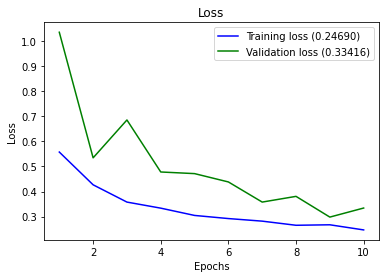

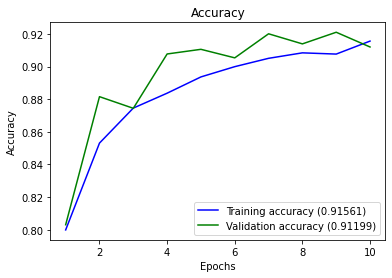

In [ ]:
mnV2.trainable = True

model_mnV2.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


history_mnV2_2 = model_mnV2.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = callbacks
                    )

plot_history(history_mnV2_2)

In [ ]:
history_mnV2_2.history

{'loss': [0.5574264526367188,
  0.4268054962158203,
  0.3578903377056122,
  0.3337008059024811,
  0.3046479821205139,
  0.292177677154541,
  0.28188806772232056,
  0.2654174864292145,
  0.267352819442749,
  0.24690409004688263],
 'accuracy': [0.7998659014701843,
  0.853084146976471,
  0.8745390772819519,
  0.883674144744873,
  0.893647313117981,
  0.8999329805374146,
  0.9050452709197998,
  0.9083976149559021,
  0.9076433181762695,
  0.9156050682067871],
 'val_loss': [1.0351485013961792,
  0.5343211889266968,
  0.68531733751297,
  0.4779197871685028,
  0.4714043140411377,
  0.438190758228302,
  0.3579183518886566,
  0.3807002305984497,
  0.29804933071136475,
  0.33415648341178894],
 'val_accuracy': [0.8030447363853455,
  0.88154137134552,
  0.8744053244590759,
  0.9077069163322449,
  0.9105613827705383,
  0.9053282737731934,
  0.9200761318206787,
  0.9138915538787842,
  0.9210276007652283,
  0.9119885563850403],
 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-

In [ ]:
results_mnV2_2 = model_mnV2.evaluate(test_generator)
print("test loss, test acc:", results_mnV2_2)

#With Lanczos interpolation

100/100 [==============================] - 7s 71ms/step - loss: 0.3713 - accuracy: 0.9190
test loss, test acc: [0.3712902367115021, 0.9190000295639038]


# **InceptionResnetV2**

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

irnV2 = InceptionResNetV2(input_shape = (150, 150, 3), 
                include_top = False, 
                weights = 'imagenet')


irnV2.trainable = False

#pre_trained_model.summary()

219062272/219055592 [==============================] - 4s 0us/step


In [ ]:
model_irnV2 = Sequential([
    irnV2,
    Flatten(),
    Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    AlphaDropout(rate=0.2),
    Dense(6, activation='softmax')
])

model_irnV2.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history_irnV2_1 = model_irnV2.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = callbacks
                    )

#With Lanczos interpolation

Epoch 1/10
373/373 [==============================] - 95s 230ms/step - loss: 1.2699 - accuracy: 0.6981 - val_loss: 0.3649 - val_accuracy: 0.8844
Epoch 2/10
373/373 [==============================] - 83s 221ms/step - loss: 0.5242 - accuracy: 0.8102 - val_loss: 0.3824 - val_accuracy: 0.8873
Epoch 3/10
373/373 [==============================] - 82s 221ms/step - loss: 0.5108 - accuracy: 0.8155 - val_loss: 0.3450 - val_accuracy: 0.8934
Epoch 4/10
373/373 [==============================] - 83s 223ms/step - loss: 0.4717 - accuracy: 0.8272 - val_loss: 0.3426 - val_accuracy: 0.8820
Epoch 5/10
373/373 [==============================] - 84s 224ms/step - loss: 0.4657 - accuracy: 0.8338 - val_loss: 0.3120 - val_accuracy: 0.9010
Epoch 6/10
373/373 [==============================] - 82s 220ms/step - loss: 0.4373 - accuracy: 0.8391 - val_loss: 0.4140 - val_accuracy: 0.8635
Epoch 7/10
373/373 [==============================] - 83s 222ms/step - loss: 0.4196 - accuracy: 0.8474 - val_loss: 0.3786 - val_ac

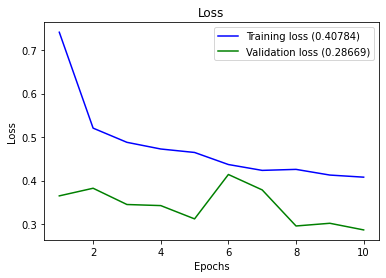

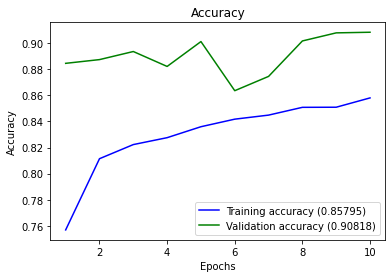

In [ ]:
plot_history(history_irnV2_1)

In [ ]:
history_irnV2_1.history

{'loss': [0.7407068610191345,
  0.5204655528068542,
  0.48787370324134827,
  0.47253814339637756,
  0.4645877778530121,
  0.4368695914745331,
  0.42342978715896606,
  0.42572808265686035,
  0.4126826226711273,
  0.40783846378326416],
 'accuracy': [0.7569561004638672,
  0.8114314675331116,
  0.8222427368164062,
  0.8275226354598999,
  0.8359034657478333,
  0.8416862487792969,
  0.8447871208190918,
  0.8507375121116638,
  0.850821316242218,
  0.8579450249671936],
 'val_loss': [0.3648778200149536,
  0.3823981285095215,
  0.3450460135936737,
  0.3425615727901459,
  0.3120255172252655,
  0.4139942526817322,
  0.3785785734653473,
  0.2957283556461334,
  0.3019428551197052,
  0.2866877019405365],
 'val_accuracy': [0.8843958377838135,
  0.8872502446174622,
  0.8934348225593567,
  0.8820171356201172,
  0.901046633720398,
  0.8634633421897888,
  0.8744053244590759,
  0.9015223383903503,
  0.9077069163322449,
  0.908182680606842],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.

In [ ]:
results_irnV2_1 = model_irnV2.evaluate(test_generator)
print("test loss, test acc:", results_irnV2_1)

#With Lanczos interpolation

100/100 [==============================] - 8s 78ms/step - loss: 0.2748 - accuracy: 0.9080
test loss, test acc: [0.2748490273952484, 0.9079999923706055]


Epoch 1/10
373/373 [==============================] - 118s 273ms/step - loss: 0.5882 - accuracy: 0.7849 - val_loss: 0.6348 - val_accuracy: 0.8806
Epoch 2/10
373/373 [==============================] - 99s 266ms/step - loss: 0.3329 - accuracy: 0.8875 - val_loss: 0.3313 - val_accuracy: 0.9148
Epoch 3/10
373/373 [==============================] - 100s 269ms/step - loss: 0.2855 - accuracy: 0.9023 - val_loss: 0.8796 - val_accuracy: 0.8972
Epoch 4/10
373/373 [==============================] - 103s 275ms/step - loss: 0.2439 - accuracy: 0.9185 - val_loss: 1.2367 - val_accuracy: 0.8887
Epoch 5/10
373/373 [==============================] - 100s 267ms/step - loss: 0.2196 - accuracy: 0.9208 - val_loss: 0.4688 - val_accuracy: 0.9177
Restoring model weights from the end of the best epoch.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 00005: early stopping


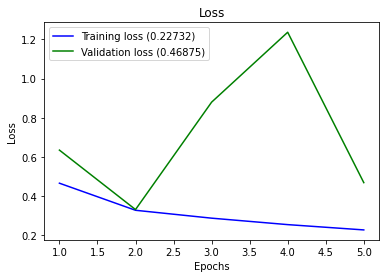

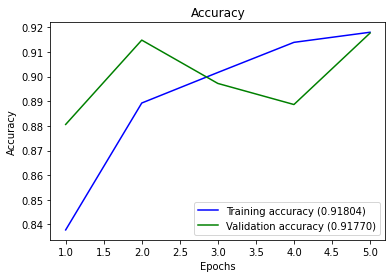

In [ ]:
irnV2.trainable = True

model_irnV2.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


history_irnV2_2 = model_irnV2.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = callbacks
                    )

plot_history(history_irnV2_2)

In [ ]:
history_irnV2_2.history

{'loss': [0.46591082215309143,
  0.3276174068450928,
  0.28734129667282104,
  0.2543668746948242,
  0.22732405364513397],
 'accuracy': [0.8377472162246704,
  0.8892893195152283,
  0.9016929268836975,
  0.9139289259910583,
  0.9180355072021484],
 'val_loss': [0.6348224878311157,
  0.33125078678131104,
  0.8796193599700928,
  1.2367126941680908,
  0.4687502086162567],
 'val_accuracy': [0.8805899024009705,
  0.9148430228233337,
  0.8972406983375549,
  0.8886774778366089,
  0.9176974296569824],
 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04]}

In [ ]:
results_irnV2_2 = model_irnV2.evaluate(test_generator)
print("test loss, test acc:", results_irnV2_2)

#With Lanczos interpolation

100/100 [==============================] - 8s 75ms/step - loss: 0.2733 - accuracy: 0.9203
test loss, test acc: [0.27334290742874146, 0.9203333258628845]


# **DenseNet201**

In [ ]:
from keras.applications.densenet import DenseNet201

dn201 = DenseNet201(input_shape = (150, 150, 3), 
                include_top = False, 
                weights = 'imagenet')


dn201.trainable = False

#pre_trained_model.summary()


74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
model_dn201 = Sequential([
    dn201,
    Flatten(),
    Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    AlphaDropout(rate=0.2),
    Dense(6, activation='softmax')
])

model_dn201.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

Epoch 1/10
373/373 [==============================] - 95s 227ms/step - loss: 1.3267 - accuracy: 0.7214 - val_loss: 0.3101 - val_accuracy: 0.8944
Epoch 2/10
373/373 [==============================] - 80s 213ms/step - loss: 0.4278 - accuracy: 0.8440 - val_loss: 0.2905 - val_accuracy: 0.9010
Epoch 3/10
373/373 [==============================] - 81s 217ms/step - loss: 0.3927 - accuracy: 0.8547 - val_loss: 0.2836 - val_accuracy: 0.9072
Epoch 4/10
373/373 [==============================] - 83s 223ms/step - loss: 0.3885 - accuracy: 0.8646 - val_loss: 0.3145 - val_accuracy: 0.9049
Epoch 5/10
373/373 [==============================] - 81s 218ms/step - loss: 0.3876 - accuracy: 0.8620 - val_loss: 0.3013 - val_accuracy: 0.9106
Epoch 6/10
373/373 [==============================] - 82s 219ms/step - loss: 0.3815 - accuracy: 0.8591 - val_loss: 0.2872 - val_accuracy: 0.9101
Restoring model weights from the end of the best epoch.

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949

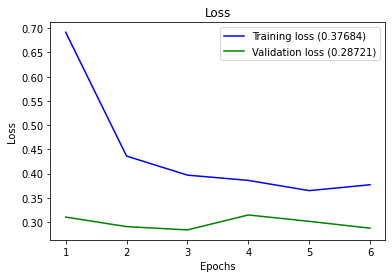

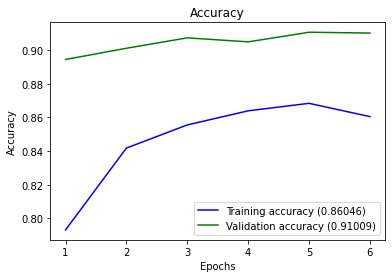

In [ ]:
history_dn201_1 = model_dn201.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = callbacks
                    )

plot_history(history_dn201_1)

#With Lanczos interpolation

In [ ]:
history_dn201_1.history

{'loss': [0.6917451024055481,
  0.4360852539539337,
  0.3967442810535431,
  0.3858424425125122,
  0.3647382855415344,
  0.37684446573257446],
 'accuracy': [0.7931612730026245,
  0.8417700529098511,
  0.8555145859718323,
  0.8638954162597656,
  0.8683372735977173,
  0.8604592680931091],
 'val_loss': [0.31010308861732483,
  0.2904733121395111,
  0.2836148142814636,
  0.31449955701828003,
  0.3013324737548828,
  0.2872117757797241],
 'val_accuracy': [0.8943862915039062,
  0.901046633720398,
  0.9072312116622925,
  0.9048525094985962,
  0.9105613827705383,
  0.9100856184959412],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}

In [ ]:
results_dn201_1 = model_dn201.evaluate(test_generator)
print("test loss, test acc:", results_dn201_1)

#With Lanczos interpolation

100/100 [==============================] - 6s 53ms/step - loss: 0.3037 - accuracy: 0.9037
test loss, test acc: [0.3037043511867523, 0.9036666750907898]


Epoch 1/10
373/373 [==============================] - 120s 272ms/step - loss: 0.4834 - accuracy: 0.8376 - val_loss: 0.5542 - val_accuracy: 0.8630
Epoch 2/10
373/373 [==============================] - 100s 269ms/step - loss: 0.3439 - accuracy: 0.8874 - val_loss: 0.3178 - val_accuracy: 0.9068
Epoch 3/10
373/373 [==============================] - 99s 265ms/step - loss: 0.2854 - accuracy: 0.9053 - val_loss: 0.3262 - val_accuracy: 0.9125
Epoch 4/10
373/373 [==============================] - 99s 266ms/step - loss: 0.2729 - accuracy: 0.9087 - val_loss: 0.3628 - val_accuracy: 0.9229
Epoch 5/10
373/373 [==============================] - 98s 263ms/step - loss: 0.2335 - accuracy: 0.9186 - val_loss: 0.3053 - val_accuracy: 0.9220
Epoch 6/10
373/373 [==============================] - 99s 265ms/step - loss: 0.2260 - accuracy: 0.9209 - val_loss: 0.3298 - val_accuracy: 0.9110
Epoch 7/10
373/373 [==============================] - 98s 262ms/step - loss: 0.2198 - accuracy: 0.9240 - val_loss: 0.3558 - val_

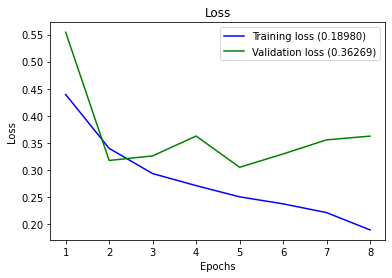

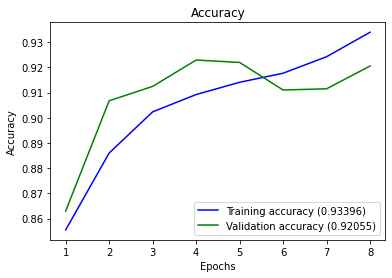

In [ ]:
dn201.trainable = True

model_dn201.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


history_dn201_2 = model_dn201.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = callbacks
                    )

plot_history(history_dn201_2)

In [ ]:
history_dn201_2.history

{'loss': [0.4394627511501312,
  0.34016484022140503,
  0.2936479151248932,
  0.2714597284793854,
  0.2507844865322113,
  0.2378886640071869,
  0.22172783315181732,
  0.18980449438095093],
 'accuracy': [0.8555145859718323,
  0.8860207796096802,
  0.9023634195327759,
  0.9092356562614441,
  0.9140965342521667,
  0.9177002906799316,
  0.9242373704910278,
  0.9339591264724731],
 'val_loss': [0.5541817545890808,
  0.31783798336982727,
  0.32624590396881104,
  0.36284852027893066,
  0.30525335669517517,
  0.3298056125640869,
  0.3558192551136017,
  0.3626869320869446],
 'val_accuracy': [0.8629876375198364,
  0.9067554473876953,
  0.9124643206596375,
  0.9229305386543274,
  0.9219790697097778,
  0.9110370874404907,
  0.9115128517150879,
  0.9205518364906311],
 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04]}

In [ ]:
results_dn201_2 = model_dn201.evaluate(test_generator)
print("test loss, test acc:", results_dn201_2)

#With Lanczos interpolation

100/100 [==============================] - 8s 84ms/step - loss: 0.2739 - accuracy: 0.9253
test loss, test acc: [0.2739469110965729, 0.9253333210945129]


# **ResNet152V2**

In [ ]:
from keras.applications.resnet_v2 import ResNet152V2

rn152V2 = ResNet152V2(input_shape = (150, 150, 3), 
                include_top = False, 
                weights = 'imagenet')


rn152V2.trainable = False

#pre_trained_model.summary()



234553344/234545216 [==============================] - 5s 0us/step


In [ ]:
model_rn152V2 = Sequential([
    rn152V2,
    Flatten(),
    Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    AlphaDropout(rate=0.2),
    Dense(6, activation='softmax')
])

model_rn152V2.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

Epoch 1/10
373/373 [==============================] - 97s 238ms/step - loss: 1.0573 - accuracy: 0.7372 - val_loss: 0.4120 - val_accuracy: 0.8877
Epoch 2/10
373/373 [==============================] - 86s 230ms/step - loss: 0.5454 - accuracy: 0.8141 - val_loss: 0.3811 - val_accuracy: 0.8877
Epoch 3/10
373/373 [==============================] - 87s 234ms/step - loss: 0.4833 - accuracy: 0.8294 - val_loss: 0.3494 - val_accuracy: 0.8963
Epoch 4/10
373/373 [==============================] - 86s 231ms/step - loss: 0.4210 - accuracy: 0.8478 - val_loss: 0.3548 - val_accuracy: 0.8944
Epoch 5/10
373/373 [==============================] - 87s 233ms/step - loss: 0.4239 - accuracy: 0.8495 - val_loss: 0.3621 - val_accuracy: 0.9068
Epoch 6/10
373/373 [==============================] - 85s 227ms/step - loss: 0.4117 - accuracy: 0.8567 - val_loss: 0.3236 - val_accuracy: 0.8968
Epoch 7/10
373/373 [==============================] - 85s 226ms/step - loss: 0.3965 - accuracy: 0.8645 - val_loss: 0.3550 - val_ac

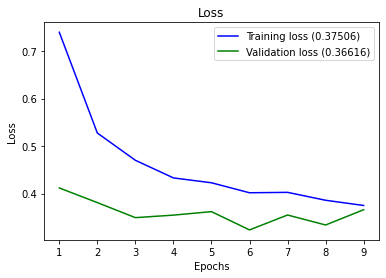

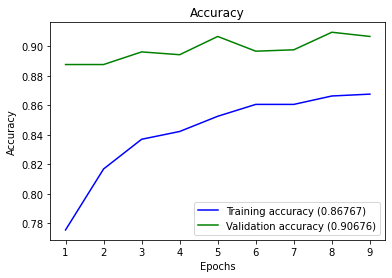

In [ ]:
history_rn152V2_1 = model_rn152V2.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = callbacks
                    )

plot_history(history_rn152V2_1)
#With Lanczos interpolation

In [ ]:
history_rn152V2_1.history

{'loss': [0.7396000623703003,
  0.527536928653717,
  0.4701576232910156,
  0.4330759346485138,
  0.422820508480072,
  0.40181782841682434,
  0.4026757478713989,
  0.3860347867012024,
  0.37506237626075745],
 'accuracy': [0.7756453156471252,
  0.8169627785682678,
  0.8370767831802368,
  0.8423566818237305,
  0.8526651263237,
  0.8607106804847717,
  0.8607106804847717,
  0.8664096593856812,
  0.8676667809486389],
 'val_loss': [0.41195937991142273,
  0.381110280752182,
  0.34944799542427063,
  0.3547535836696625,
  0.3621097803115845,
  0.3236342668533325,
  0.3550037145614624,
  0.3339833915233612,
  0.3661581873893738],
 'val_accuracy': [0.8877259492874146,
  0.8877259492874146,
  0.8962892293930054,
  0.8943862915039062,
  0.9067554473876953,
  0.8967649936676025,
  0.8977164626121521,
  0.9096099138259888,
  0.9067554473876953],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}

In [ ]:
results_rn152V2_1 = model_rn152V2.evaluate(test_generator)
print("test loss, test acc:", results_rn152V2_1)

#With Lanczos interpolation

100/100 [==============================] - 8s 80ms/step - loss: 0.3426 - accuracy: 0.8993
test loss, test acc: [0.3426419198513031, 0.8993333578109741]


Epoch 1/10
373/373 [==============================] - 131s 312ms/step - loss: 0.6576 - accuracy: 0.7823 - val_loss: 0.3552 - val_accuracy: 0.9039
Epoch 2/10
373/373 [==============================] - 111s 299ms/step - loss: 0.3801 - accuracy: 0.8763 - val_loss: 0.2692 - val_accuracy: 0.9206
Epoch 3/10
373/373 [==============================] - 112s 301ms/step - loss: 0.3330 - accuracy: 0.8848 - val_loss: 0.2780 - val_accuracy: 0.9153
Epoch 4/10
373/373 [==============================] - 112s 300ms/step - loss: 0.2860 - accuracy: 0.9024 - val_loss: 0.3796 - val_accuracy: 0.9106
Epoch 5/10
373/373 [==============================] - 112s 301ms/step - loss: 0.2846 - accuracy: 0.9025 - val_loss: 0.3011 - val_accuracy: 0.9167
Restoring model weights from the end of the best epoch.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 00005: early stopping


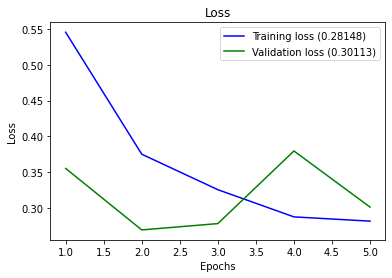

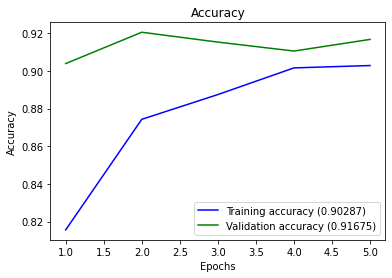

In [ ]:
rn152V2.trainable = True

model_rn152V2.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


history_rn152V2_2 = model_rn152V2.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = callbacks
                    )

plot_history(history_rn152V2_2)

In [ ]:
history_rn152V2_2.history

{'loss': [0.5455675721168518,
  0.37504979968070984,
  0.3254442512989044,
  0.28741565346717834,
  0.28148236870765686],
 'accuracy': [0.8155380487442017,
  0.8742876052856445,
  0.8874455094337463,
  0.9016091227531433,
  0.9028662443161011],
 'val_loss': [0.3551768362522125,
  0.26920029520988464,
  0.2780378758907318,
  0.37956860661506653,
  0.30112847685813904],
 'val_accuracy': [0.9039010405540466,
  0.9205518364906311,
  0.9153187274932861,
  0.9105613827705383,
  0.9167459607124329],
 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04]}

In [ ]:
results_rn152V2_2 = model_rn152V2.evaluate(test_generator)
print("test loss, test acc:", results_rn152V2_2)

#With Lanczos interpolation

100/100 [==============================] - 8s 76ms/step - loss: 0.2769 - accuracy: 0.9123
test loss, test acc: [0.2768535912036896, 0.9123333096504211]


# **Xception**

In [ ]:
from keras.applications.xception import Xception

xcept = Xception(input_shape = (150, 150, 3), 
                include_top = False, 
                weights = 'imagenet')


xcept.trainable = False

#pre_trained_model.summary()



83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
model_xcept = Sequential([
    xcept,
    Flatten(),
    Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    AlphaDropout(rate=0.2),
    Dense(6, activation='softmax')
])

model_xcept.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

Epoch 1/10
373/373 [==============================] - 81s 211ms/step - loss: 1.0473 - accuracy: 0.7246 - val_loss: 0.3928 - val_accuracy: 0.8673
Epoch 2/10
373/373 [==============================] - 78s 209ms/step - loss: 0.5761 - accuracy: 0.7986 - val_loss: 0.4115 - val_accuracy: 0.8749
Epoch 3/10
373/373 [==============================] - 79s 211ms/step - loss: 0.5317 - accuracy: 0.8091 - val_loss: 0.3543 - val_accuracy: 0.8811
Epoch 4/10
373/373 [==============================] - 81s 216ms/step - loss: 0.4908 - accuracy: 0.8210 - val_loss: 0.3213 - val_accuracy: 0.8844
Epoch 5/10
373/373 [==============================] - 78s 209ms/step - loss: 0.4844 - accuracy: 0.8303 - val_loss: 0.3392 - val_accuracy: 0.8901
Epoch 6/10
373/373 [==============================] - 78s 209ms/step - loss: 0.4610 - accuracy: 0.8361 - val_loss: 0.3428 - val_accuracy: 0.8801
Epoch 7/10
373/373 [==============================] - 78s 210ms/step - loss: 0.4517 - accuracy: 0.8310 - val_loss: 0.3231 - val_ac

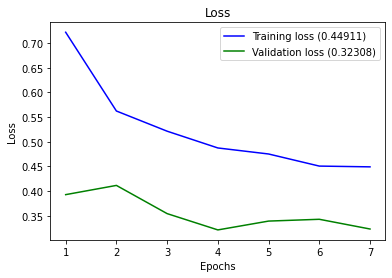

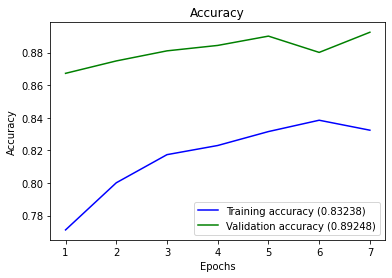

In [ ]:
history_xcept_1 = model_xcept.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = callbacks
                    )

plot_history(history_xcept_1)

#With Lanczos interpolation

In [ ]:
history_xcept_1.history

{'loss': [0.7220008373260498,
  0.562333881855011,
  0.5213952660560608,
  0.4874168038368225,
  0.47518032789230347,
  0.4506547152996063,
  0.44910669326782227],
 'accuracy': [0.7712034583091736,
  0.8001173138618469,
  0.8173818588256836,
  0.822996973991394,
  0.8315454125404358,
  0.838501513004303,
  0.8323835134506226],
 'val_loss': [0.3927736282348633,
  0.41147297620773315,
  0.35429808497428894,
  0.3212531805038452,
  0.33915960788726807,
  0.3428060710430145,
  0.3230835199356079],
 'val_accuracy': [0.8672692775726318,
  0.8748810887336731,
  0.8810656666755676,
  0.8843958377838135,
  0.8901046514511108,
  0.8801141977310181,
  0.8924833536148071],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}

In [ ]:
results_xcept_1 = model_xcept.evaluate(test_generator)
print("test loss, test acc:", results_xcept_1)

#With Lanczos interpolation

100/100 [==============================] - 5s 49ms/step - loss: 0.3254 - accuracy: 0.8807
test loss, test acc: [0.32539916038513184, 0.8806666731834412]


Epoch 1/10
373/373 [==============================] - 107s 275ms/step - loss: 0.5957 - accuracy: 0.7863 - val_loss: 0.3122 - val_accuracy: 0.9110
Epoch 2/10
373/373 [==============================] - 103s 277ms/step - loss: 0.3436 - accuracy: 0.8839 - val_loss: 0.2506 - val_accuracy: 0.9167
Epoch 3/10
373/373 [==============================] - 104s 277ms/step - loss: 0.2681 - accuracy: 0.9066 - val_loss: 0.2079 - val_accuracy: 0.9329
Epoch 4/10
373/373 [==============================] - 102s 272ms/step - loss: 0.2346 - accuracy: 0.9172 - val_loss: 0.2380 - val_accuracy: 0.9286
Epoch 5/10
373/373 [==============================] - 100s 269ms/step - loss: 0.2110 - accuracy: 0.9277 - val_loss: 0.2345 - val_accuracy: 0.9282
Epoch 6/10
373/373 [==============================] - 102s 273ms/step - loss: 0.1846 - accuracy: 0.9366 - val_loss: 0.2534 - val_accuracy: 0.9301
Restoring model weights from the end of the best epoch.

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.99999994

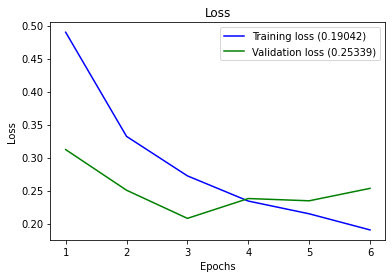

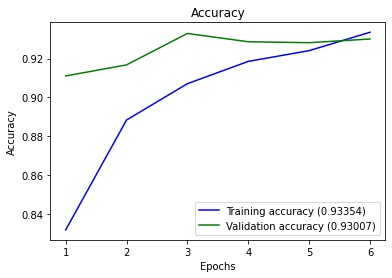

In [ ]:
xcept.trainable = True

model_xcept.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


history_xcept_2 = model_xcept.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = callbacks
                    )

plot_history(history_xcept_2)

In [ ]:
history_xcept_2.history

{'loss': [0.4899950921535492,
  0.3321731388568878,
  0.27234894037246704,
  0.2341735064983368,
  0.21485647559165955,
  0.19042323529720306],
 'accuracy': [0.8317968249320984,
  0.8883674144744873,
  0.9070566296577454,
  0.9185383915901184,
  0.9240697026252747,
  0.9335400462150574],
 'val_loss': [0.3121653199195862,
  0.25058379769325256,
  0.20791862905025482,
  0.23798686265945435,
  0.23454996943473816,
  0.2533915936946869],
 'val_accuracy': [0.9110370874404907,
  0.9167459607124329,
  0.9329210519790649,
  0.9286394119262695,
  0.9281636476516724,
  0.9300665855407715],
 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04]}

In [ ]:
results_xcept_2 = model_xcept.evaluate(test_generator)
print("test loss, test acc:", results_xcept_2)

#With Lanczos interpolation

100/100 [==============================] - 7s 75ms/step - loss: 0.2335 - accuracy: 0.9243
test loss, test acc: [0.23345845937728882, 0.9243333339691162]


# **StackEnsemble Deep Learning**

In [ ]:
pip install deepstack

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from deepstack.base import KerasMember
from deepstack.ensemble import StackEnsemble
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

## **Originally**

InceptV3: **accuracy: 0.92**

Rn152V2: **accuracy: 0.9123**

MNV2: **accuracy: 0.919**

## **After Stacking those 3 models**

w/ 1 layer of Meta-Learner (RFC): **accuracy: 0.9347**

w/ 2 layers of Meta-Learners (LFC, RTC as 1st layer, RFC as 2nd layer): **accuracy: 0.935**

w/ 2 layers of Meta-Learners (LFC, BC as 1st layer, RFC as 2nd layer): **accuracy: 0.936**


In [ ]:
member1 = KerasMember(name="model_inceptV3", keras_model = model_inceptV3, train_batches = train_generator, val_batches = test_generator)
member2 = KerasMember(name="model_rn152V2", keras_model = model_rn152V2, train_batches = train_generator, val_batches = test_generator)
member3 = KerasMember(name="model_mnV2", keras_model = model_mnV2, train_batches = train_generator, val_batches = test_generator)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


101/101 [==============================] - 5s 46ms/step


In [ ]:
# 1 level of Meta-Leaner

stack = StackEnsemble()
stack.model = RandomForestClassifier(verbose=0, n_estimators = 900,
                                    max_depth = 6, n_jobs = 4)

stack.add_members([member1, member2, member3])
stack.fit()
stack.describe(metric = sklearn.metrics.accuracy_score)

Calling predict
model_inceptV3 - accuracy_score: 0.9928
model_rn152V2 - accuracy_score: 0.9916
model_mnV2 - accuracy_score: 0.9928
StackEnsemble accuracy_score: 0.9347


0.9346666666666666

In [ ]:
stack = StackEnsemble()

# 2nd Level Meta-Learner
estimators = [
    ('lf', LogisticRegression()),
    ('etr', ExtraTreesClassifier(verbose=0, n_estimators=900, max_depth=6, n_jobs=4))
]
# 3rd Level Meta-Learner
clf = StackingClassifier(
    estimators=estimators, final_estimator = RandomForestClassifier(verbose=0, n_estimators=900, max_depth=6, n_jobs=4)
)

stack.model = clf
stack.add_members([member1, member2, member3])
stack.fit()
stack.describe(metric=sklearn.metrics.accuracy_score)

Calling predict
model_inceptV3 - accuracy_score: 0.9928
model_rn152V2 - accuracy_score: 0.9916
model_mnV2 - accuracy_score: 0.9928
StackEnsemble accuracy_score: 0.9350


0.935

In [ ]:
### OtherVersion

stack = StackEnsemble()

# 2nd Level Meta-Learner
estimators = [
    ('lf', LogisticRegression()),
    ('bag', BaggingClassifier(verbose=0, n_estimators=900, n_jobs=4))
]
# 3rd Level Meta-Learner
clf = StackingClassifier(
    estimators=estimators, final_estimator = RandomForestClassifier(verbose=0, n_estimators=900, max_depth=6, n_jobs=4)
)

stack.model = clf
stack.add_members([member1, member2, member3])
stack.fit()
stack.describe(metric=sklearn.metrics.accuracy_score)

Calling predict
model_inceptV3 - accuracy_score: 0.9928
model_rn152V2 - accuracy_score: 0.9916
model_mnV2 - accuracy_score: 0.9928
StackEnsemble accuracy_score: 0.9360


0.936